In [57]:
import numpy as np
import time
import numba
import torch
from utils.architecture import CNN

def kolmogorov_functional(config, weight, model, eps=1e-12):
    # config: [B,1,H,W], weight: [B]
    #print(config.shape)
    x = config.detach().float().requires_grad_(True)
    #print(x.shape)
    y = model(x)
    grad_outputs = torch.ones_like(y)

    g = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=grad_outputs,
        create_graph=True,     # needed if this loss trains the model
        retain_graph=True,
    )[0]  # g: [B,1,H,W]

    grad_square = torch.pow(g, 2)

    per_sample = weight * grad_square.sum(dim=(1,2,3))  # [B]

    return per_sample.clamp_min(eps).mean()

def committor_functional(config, model, eps=1e-12):
    #model.eval()
    x = config.detach().float().requires_grad_(True)
    y = model(x)
    (grads,) = torch.autograd.grad(outputs=y, inputs=x, retain_graph=False, create_graph=False)

    return torch.sum(grads ** 2) + eps

def loss_func(config, tags, weight, model, alpha=1.0):
    mask_up = (tags == 1)
    mask_dn = (tags == 0)
    mask_n = (tags == 2)

    loss = 0.0
    #print(mask_up)
    #print(tags)

    # Kolmogorov term (mean over batch)
    #if mask_n.any():
    kf = 0.0#kolmogorov_functional(config, weight, model)
    loss = kf

    # boundary up: q(x)=1
    up = 0.0
    if mask_up.any():
        out_up = model(config[mask_up]).squeeze(-1)
        up = alpha * (out_up - 1.0).square().mean()
        loss = loss + up

    # boundary down: q(x)=0
    dn = 0.0
    if mask_dn.any():
        out_dn = model(config[mask_dn]).squeeze(-1)
        dn = alpha * (out_dn - 0.0).square().mean()
        loss = loss + dn

    return loss, kf, up, dn


@numba.njit
def metropolis(spin, sweeps, L, beta, exponent):
    for _ in range(L ** 2 * sweeps):
        # randomly sample a spin
        x = np.random.randint(0, L)
        y = np.random.randint(0, L)
        s = spin[x, y]

        # Sum of the spins of nearest neighbors
        xpp = (x + 1) % L
        ypp = (y + 1) % L
        xnn = (x - 1) % L
        ynn = (y - 1) % L
        R = spin[xpp, y] + spin[x, ypp] + spin[xnn, y] + spin[x, ynn]

        index = 5*(s+1) + R + 4
        
        if np.random.rand() < np.exp(-beta * exponent[index]):  # Probability of the flipped state is higher -> flip the spin
            spin[x, y] = -s

@torch.no_grad()
def metropolis_biased(spin, sweeps, beta, L, exponent, model):
    k = 1000
    #q_unswapped = model(spin)
    bias_unswapped = -k*(model(spin)-0.5)**2
    for _ in range(L ** 2 * sweeps):
        # randomly sample a spin
        x = torch.randint(0, L, (1,), device=spin.device)
        y = torch.randint(0, L, (1,), device=spin.device)
        s = spin[0, 0, x, y]

        # Sum of the spins of nearest neighbors
        xpp = (x + 1) % L
        ypp = (y + 1) % L
        xnn = (x - 1) % L
        ynn = (y - 1) % L
        R = spin[0, 0, xpp, y] + spin[0, 0, x, ypp] + spin[0, 0, xnn, y] + spin[0, 0, x, ynn]

        index = int(5*(s+1) + R + 4)

        spin[0, 0, x, y] = -s
        #q_swapped = model(spin)
        bias_swapped = -k*(model(spin)-0.5)**2

        #print((-beta * exponent[index]).item(), (bias_swapped - bias_unswapped).item(), q_unswapped.item(), q_swapped.item())
  
        if torch.rand(1, device=spin.device) < torch.exp(-beta * exponent[index] + (bias_swapped - bias_unswapped)):  # Probability of the flipped state is higher -> flip the spin
            bias_unswapped = bias_swapped
            #q_unswapped = q_swapped
        else:
            spin[0, 0, x, y] = s

class IsingModel2D:
    def __init__(self, args):
        self.L = args.L
        self.output = args.output
        self.mcsweeps = args.mcsweeps
        self.area = self.L ** 2
        self.J = args.J
        self.h = args.h
        self.beta = args.beta
        self.init_mode = args.init_mode
        self.model = args.model if hasattr(args, 'model') else None
        self.grid = args.grid if hasattr(args, 'grid') else None

    def init_spin(self, mode='random'):
        if mode == 'up':
            return np.ones((self.L, self.L), dtype=np.int8)
        elif mode == 'down':
            return -np.ones((self.L, self.L), dtype=np.int8)
        elif mode == 'random':
            return 2 * np.random.randint(2, size=(self.L, self.L), dtype=np.int8) - 1
        elif mode == 'grid':
            return self.grid
        
        
    def pre_compute_acceptance(self, h):
        # Pre-compute acceptance probabilities for all possibilities
        # s  : nsum               : index 5*(s+1) + nsum + 4
        # +1 : -4 = -1 -1 -1 -1   : 10
        # +1 : -2 = -1 -1 -1 +1   : 12
        # +1 :  0 = -1 -1 +1 +1   : 14
        # +1 : +2 = -1 +1 +1 +1   : 16
        # +1 : +4 = +1 +1 +1 +1   : 18
        # -1 : -4 = -1 -1 -1 -1   : 0
        # -1 : -2 = -1 -1 -1 +1   : 2
        # -1 :  0 = -1 -1 +1 +1   : 4
        # -1 : +2 = -1 +1 +1 +1   : 6
        # -1 : +4 = +1 +1 +1 +1   : 8

        exponent = np.zeros(20)

        for s in [-1, 1]:
            for nsum in range(-4, 5, 2):
                index = 5*(s+1) + nsum + 4
                exponent[index] = 2.0 * s * (nsum + h)
        return exponent
    
    @staticmethod
    # Calculate energy using neighbors
    def calc_energy(spin, J, h, area):
        R = np.roll(spin, 1, axis=0) + np.roll(spin, -1, axis=0) + np.roll(spin, 1, axis=1) + np.roll(spin, -1, axis=1)
        return (J * np.sum(-R * spin) / 4 - h * np.sum(spin)) / area
    
    @staticmethod
    def calc_magnetization(spin, area):
        return np.sum(spin) / area
    
    @staticmethod
    def calc_energy_torch(spin, J, h, area):
        s = spin[0, 0] if spin.dim() == 4 else spin
        s = s.to(torch.float32)
        R = torch.roll(s, 1, 0) + torch.roll(s, -1, 0) + torch.roll(s, 1, 1) + torch.roll(s, -1, 1)
        return (J * (-R * s).sum() / 4.0 - h * s.sum()) / float(area)

    @staticmethod
    def calc_magnetization_torch(spin, area):
        s = spin[0, 0] if spin.dim() == 4 else spin
        return s.to(torch.float32).sum() / float(area)

    def simulate(self):
        spin = self.init_spin(mode=self.init_mode)
        exponent = self.pre_compute_acceptance(self.h)
        magnetization = np.zeros(self.mcsweeps // self.output)
        energy = np.zeros(self.mcsweeps // self.output)
        grids = np.zeros((self.mcsweeps // self.output, self.L, self.L), dtype=np.int8)
        
        for i in range(self.mcsweeps // self.output):
            metropolis(spin, self.output, self.L, self.beta, exponent)
            energy[i] = self.calc_energy(spin, self.J, self.h, self.area)
            magnetization[i] = self.calc_magnetization(spin, self.area)
            grids[i] = spin.copy()
            print(f"Step {i*self.output}: Energy = {energy[i]}, Magnetization = {magnetization[i]}")
        return energy, magnetization, grids
    
    def simulate_biased(self):
        spin = torch.tensor(self.init_spin(mode=self.init_mode), dtype=torch.float32, device=next(self.model.parameters()).device)
        spin = spin.unsqueeze(0).unsqueeze(0)
        exponent = torch.tensor(self.pre_compute_acceptance(self.h), device=spin.device)
        magnetization = torch.zeros(self.mcsweeps // self.output, device=spin.device)
        energy = torch.zeros(self.mcsweeps // self.output, device=spin.device)
        grids = torch.zeros((self.mcsweeps // self.output, self.L, self.L), dtype=torch.float32, device=spin.device)
        
        for i in range(self.mcsweeps // self.output):
            metropolis_biased(spin, self.output, self.beta, self.L, exponent, self.model)
            energy[i] = self.calc_energy_torch(spin, self.J, self.h, self.area)
            magnetization[i] = self.calc_magnetization_torch(spin, self.area)
            grids[i] = spin
            print(f"Step {i*self.output}: Energy = {energy[i]}, Magnetization = {magnetization[i]}, Commitor = {self.model(spin).item()}")
        return energy, magnetization, grids

In [2]:
from torch.utils.data import Dataset
class IsingDataset(Dataset):
    def __init__(self, L: int, device="cpu", grid_dtype=torch.float32, init_capacity=1024):
        self.L = L
        self.device = device
        self.grid_dtype = grid_dtype

        self.capacity = int(init_capacity)
        self.size = 0

        self.grids = torch.empty((self.capacity, 1, L, L), dtype=grid_dtype, device=device)
        self.tags = torch.empty((self.capacity,), dtype=torch.int8, device=device)
        self.weights = torch.empty((self.capacity,), dtype=torch.float32, device=device)
        self.committor = torch.empty((self.capacity,), dtype=torch.float32, device=device)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.grids[idx], self.tags[idx], self.weights[idx], self.committor[idx]
    
    @torch.no_grad()
    def append(self, grid, tag, weight: float = 1.0, committor: float = 0.0):
        g = torch.as_tensor(grid, device=self.device)
        if g.dim() == 2:
            g = g.unsqueeze(0)  # [1,L,L]
        if g.shape != (1, self.L, self.L):
            raise ValueError(f"grid must have shape [1,{self.L},{self.L}] or [{self.L},{self.L}], got {tuple(g.shape)}")

        self.grids[self.size].copy_(g.to(self.grid_dtype))
        self.tags[self.size] = tag
        self.weights[self.size] = weight
        self.committor[self.size] = committor

        self.size += 1

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(
    channels=32,
    num_cnn_layers=4,
    num_fc_layers=2,
).to(device)

# Model parameters
batch_size = 256
learning_rate = 1e-3
num_epochs = 32
weight_decay = 1e-4

decay, no_decay = [], []
for name, param in model.named_parameters():
    if "bn" in name or "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)

# Optimizer
optimizer = torch.optim.AdamW([
    {'params': decay, 'weight_decay': weight_decay},
    {'params': no_decay, 'weight_decay': 0.0}
], lr=learning_rate)

In [31]:
class Args:
    def __init__(self):
        self.L = 64          # Lattice size (e.g., 64x64 grid)
        self.output = 1   # Output frequency (print every 1000 steps)
        self.mcsweeps = 10  # Total Monte Carlo Sweeps
        self.J = 1.0         # Coupling constant
        self.h = 0.1         # External field
        self.beta = 0.588      # Inverse temperature (1/T)
        self.init_mode = 'random'  # Initial spin configuration mode

args = Args()

In [32]:
args.mcsweeps = 10
args.init_mode = 'up'
simulator = IsingModel2D(args)
_, _, boundary_up_max = simulator.simulate()

args.init_mode = 'down'
simulator = IsingModel2D(args)
_, _, boundary_dn = simulator.simulate()

Step 0: Energy = -1.079931640625, Magnetization = 0.98974609375
Step 1: Energy = -1.0685546875, Magnetization = 0.9833984375
Step 2: Energy = -1.068017578125, Magnetization = 0.98291015625
Step 3: Energy = -1.06171875, Magnetization = 0.978515625
Step 4: Energy = -1.0623046875, Magnetization = 0.9794921875
Step 5: Energy = -1.048388671875, Magnetization = 0.97216796875
Step 6: Energy = -1.05517578125, Magnetization = 0.9765625
Step 7: Energy = -1.057470703125, Magnetization = 0.97509765625
Step 8: Energy = -1.0443359375, Magnetization = 0.970703125
Step 9: Energy = -1.040234375, Magnetization = 0.9638671875
Step 0: Energy = -0.874072265625, Magnetization = -0.98583984375
Step 1: Energy = -0.848876953125, Magnetization = -0.96923828125
Step 2: Energy = -0.84599609375, Magnetization = -0.9638671875
Step 3: Energy = -0.831298828125, Magnetization = -0.95458984375
Step 4: Energy = -0.8314453125, Magnetization = -0.953125
Step 5: Energy = -0.830419921875, Magnetization = -0.95361328125
Step

In [60]:
from utils.dataset import prepare_subset, prepare_datasets
from utils.config import load_config

# --- Load Config ---
config = load_config("config.yaml")

print(config)

beta = args.beta
h = args.h

# --- Dataset ---
h5path = f"../data/gridstates_training_{beta:.3f}_{h:.3f}.hdf5"
print(f"Loading dataset from {h5path}...")
batch_size = config.dataset.batch_size
test_size = config.dataset.test_size

grids, attrs, train_idx, valid_idx, test_idx = prepare_subset(h5path, test_size=test_size)
train_dl, valid_dl, test_dl, train_ds, valid_ds, test_ds = prepare_datasets(
    grids, attrs, train_idx, valid_idx, test_idx,
    "cpu",
    batch_size,
    augment=False
)

y_train = np.array([train_ds[i][1].item() for i in range(len(train_ds))])

idx = np.argsort(np.abs(y_train - 1))[:10]
boundary_up = [train_ds[i][0] for i in idx]

Loading dataset from ../data/gridstates_training_0.588_0.100.hdf5...
Loading attributes...
Loaded headers and attributes for 11200 entries.
Elapsed time: 0.00 s
Applying uniform filter to select 10000 samples
Selected 10000 samples as uniformly as possible across 10 bins
Loading selected grids...
Loaded 10000 grids and attributes into memory.
Elapsed time: 0.60 s
6000 2000 2000
Train size: 6000, Validation size: 2000, Test size: 2000
DataLoaders created: train_batches=47, valid_batches=16, test_batches=16


In [61]:
ds = IsingDataset(args.L, device="cpu", grid_dtype=torch.int8, init_capacity=1000)

for grid in boundary_dn:
    ds.append(grid, tag=0, committor=0.0)

for grid in boundary_up:
    ds.append(grid, tag=1, committor=1.0)

for grid in boundary_up_max:
    ds.append(grid, tag=1, committor=1.0)

print(len(ds), ds[0][0].shape, ds[0][1], ds[0][2])


30 torch.Size([1, 64, 64]) tensor(0, dtype=torch.int8) tensor(1.)


In [62]:
from torch.utils.data import DataLoader

loader = DataLoader(ds, batch_size=64, num_workers=0, pin_memory=True)

In [67]:
for epoch in range(32):
    model.train()
    optimizer.zero_grad()
    
    batch_loss = torch.zeros(1, device=device)
    batch_kf = torch.zeros(1, device=device)
    batch_up = torch.zeros(1, device=device)
    batch_dn = torch.zeros(1, device=device)
    for grids, tags, weight, _ in loader:
        grids = grids.to(device, non_blocking=True).float()
        #print(grids.shape)
        tags = tags.to(device, non_blocking=True)
        #print(tags)
        weight = weight.to(device, non_blocking=True)
        loss, kf, up, dn = loss_func(grids, tags, weight, model, alpha=1.0)
        loss.backward()
        batch_loss += loss
        batch_kf += kf
        batch_up += up
        batch_dn += dn
    
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {batch_loss.item():.14f}, Kolmogorov: {batch_kf.item():.14f}, Boundary Up: {batch_up.item():.14f}, Boundary Down: {batch_dn.item():.14f}")

Epoch 1/32, Loss: 0.00000001345965, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000001345965
Epoch 2/32, Loss: 0.00000002562808, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000002562808
Epoch 3/32, Loss: 0.00000001171322, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000001171322
Epoch 4/32, Loss: 0.00000001030075, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000001030075
Epoch 5/32, Loss: 0.00000007516963, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000007516963
Epoch 6/32, Loss: 0.00000000979883, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000000979883
Epoch 7/32, Loss: 0.00000000481466, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, Boundary Down: 0.00000000481466
Epoch 8/32, Loss: 0.00000002342088, Kolmogorov: 0.00000000000000, Boundary Up: 0.00000000000000, 

In [54]:
model.eval()
model(boundary_up[2].unsqueeze(0).to(device).float())

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)

After iteration, RMSE on training set: 0.440169


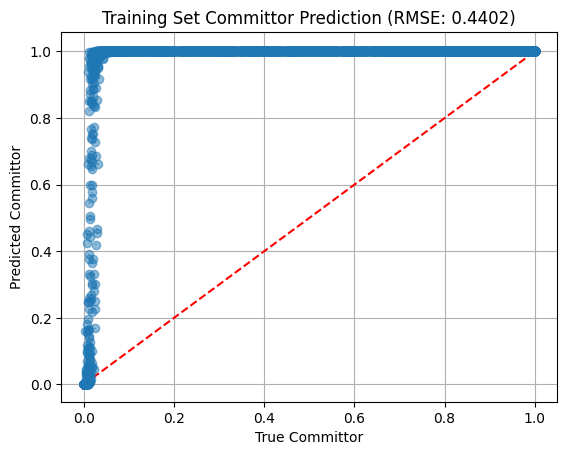

In [68]:
import matplotlib.pyplot as plt

model.eval()

chunk_size = 1024
predictions = []
for i in range(0, len(train_ds), chunk_size):
    end_idx = min(i + chunk_size, len(train_ds))
    batch = torch.stack([train_ds[j][0] for j in range(i, end_idx)]).to(device)
    with torch.no_grad():
        batch_preds = model(batch).squeeze().cpu().numpy()
        if batch_preds.ndim == 1:
            batch_preds = np.array([batch_preds])
            predictions.extend(batch_preds[0])


y_train = np.array([train_ds[i][1].item() for i in range(len(train_ds))])
y_train_err = attrs[:,3][train_idx]

predictions = np.array(predictions)
rmse = np.sqrt(np.mean((predictions - y_train)**2))

print(f"After iteration, RMSE on training set: {rmse:.6f}")

plt.errorbar(y_train, predictions, yerr=y_train_err, fmt='o', alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True Committor")
plt.ylabel("Predicted Committor")
plt.title(f"Training Set Committor Prediction (RMSE: {rmse:.4f})")
plt.grid()
plt.show()

In [29]:
model.eval()
#init_grid = train_ds[np.argmin(abs(y_train-0.5))][0]
# committor values for everything in the dataset (assumes ds stores them as ds.committor or 4th return)
N = len(ds)

for i in range(len(ds)):
    grid, _, _, _ = ds[i]
    grid = grid.to(device, non_blocking=True).float()
    ds.committor[i] = model(grid.unsqueeze(0)).item()

# If committor is stored as 4th item: (grid, tag, weight, committor)
comm = torch.tensor([float(ds[i][3]) for i in range(N)])

samples = 10

thr=0.05
idx_dn = torch.nonzero(comm.abs() <= thr, as_tuple=False).flatten()
idx_up = torch.nonzero((comm - 1.0).abs() <= thr, as_tuple=False).flatten()
idx = torch.cat([idx_dn, idx_up], dim=0)

if idx.numel() == 0:
    print("No samples near committor 0 or 1. Using random sample from whole dataset.")
    j = torch.randint(0, N, (samples,)).tolist()
else:
    j = idx[torch.randint(0, idx.numel(), (samples,))].tolist()

L = 64
beta = 0.588
sweeps = 100
exponent = simulator.pre_compute_acceptance(args.h)

grids = torch.zeros((samples, L, L), dtype=torch.float32, device=device)

for i in range(samples):
    init_grid = ds[j[i]][0]
    spin_init = init_grid.squeeze().numpy().astype(np.int8)
    spin = spin_init.copy()
    print("Initial Magnetization:", init_grid.sum().item()/64/64)
    for _ in range(int(sweeps)):
        metropolis(spin, 1, L, beta, exponent)

        spin_init_tensor = torch.tensor(spin_init, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
        spin_tensor = torch.tensor(spin, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

        #print(spin_init_tensor.sum()-spin_tensor.sum())
        bias_init = torch.log(committor_functional(spin_init_tensor, model) + 1e-12)
        bias_final = torch.log(committor_functional(spin_tensor, model) + 1e-12)
        #print("Probability:", torch.exp(bias_final - bias_init).item(), "Bias Init:", bias_init.item(), "Bias Final:", bias_final.item())
        if torch.rand(1, device=device) < torch.exp(bias_final - bias_init):
            #print("Accepted full step")
            spin_init = spin.copy()

        else:
            #print("Rejected full step")
            spin = spin_init.copy()

    grids[i] = spin_init_tensor
    #print("Committor Init:", model(spin_init_tensor).item(), "Committor Final:", model(spin_tensor).item())
    #print("Bias Init:", bias_init.item(), "Bias Final:", bias_final.item(), "Probability:", torch.exp(bias_final - bias_init).item())
    print("Magenetisation:", spin_init_tensor.sum().item()/64/64)
    #print("-----")

Initial Magnetization: -0.986328125
Magenetisation: -0.9462890625
Initial Magnetization: -0.818359375
Magenetisation: -0.68994140625
Initial Magnetization: 0.98876953125
Magenetisation: 0.97900390625
Initial Magnetization: 0.970703125
Magenetisation: 0.97021484375
Initial Magnetization: -0.96435546875
Magenetisation: -0.958984375
Initial Magnetization: -0.82958984375
Magenetisation: -0.80224609375
Initial Magnetization: -0.9697265625
Magenetisation: -0.953125
Initial Magnetization: -0.96337890625
Magenetisation: -0.9453125
Initial Magnetization: -0.95166015625
Magenetisation: -0.927734375
Initial Magnetization: -0.94580078125
Magenetisation: -0.9404296875


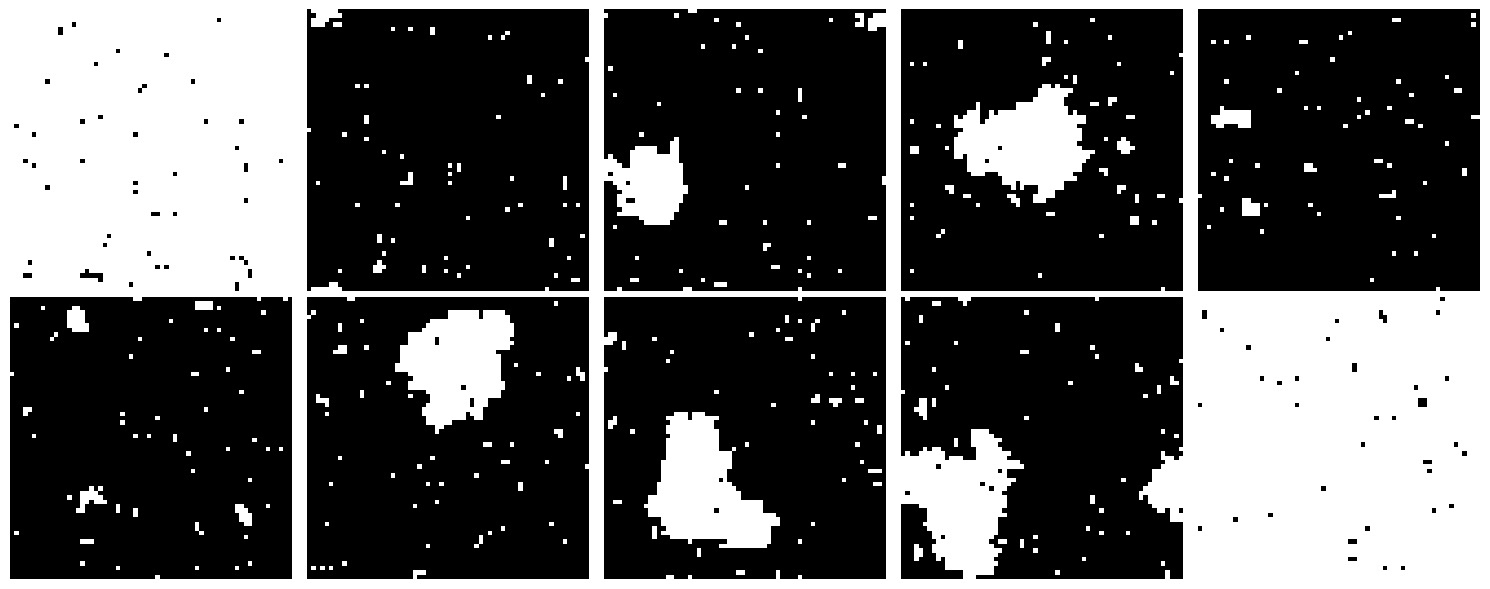

In [25]:
import matplotlib.pyplot as plt

N = grids.shape[0]
last = min(10, N)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for k in range(last):
    idx = N - last + k
    grid = grids[idx].squeeze()  # [L,L]

    axes[k].imshow(grid.detach().cpu().numpy(), cmap="gray")
    axes[k].axis("off")

# if fewer than 10, hide remaining axes
for k in range(last, 10):
    axes[k].axis("off")

plt.tight_layout()
plt.show()


In [26]:
for grid in grids:
    ds.append(grid, tag=2)

print(len(ds))

weight_sum = 0.0

for i in range(len(ds) - len(grids), len(ds)):
    grid, _, _, _ = ds[i]
    grid = grid.to(device, non_blocking=True).float()
    weight = 1.0/committor_functional(grid.unsqueeze(0), model)
    weight = weight.cpu()
    weight_sum += weight
    ds.weights[i] = weight

for i in range(len(ds)):
    grid, _, _, _ = ds[i]
    grid = grid.to(device, non_blocking=True).float()
    ds.committor[i] = model(grid.unsqueeze(0)).item()

ds.weights[len(ds) - len(grids):len(ds)] /= weight_sum/len(grids)
print("Total weight:", ds.weights[:len(ds)].sum().item())
print("Weights:", ds.weights[:len(ds)])
print("Committors:", ds.committor[:len(ds)])

40
Total weight: 40.0
Weights: tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.4286e+00, 1.2384e-11, 1.4286e+00, 1.4286e+00, 3.5563e-12, 3.3678e-12,
        1.4286e+00, 1.4286e+00, 1.4286e+00, 1.4286e+00])
Committors: tensor([1.3514e-04, 1.3914e-04, 1.4917e-04, 1.5503e-04, 1.6136e-04, 1.5392e-04,
        1.5783e-04, 1.5552e-04, 1.5621e-04, 1.4688e-04, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 

In [ ]:
print("Committors:", ds.committor[:len(ds)])

In [ ]:
model.eval()
init_grid = grids[0:1].requires_grad_(True)  # [1,1,L,L]
final_grid = init_grid.clone()
x = torch.randint(0, args.L, (1,), device=init_grid.device)
y = torch.randint(0, args.L, (1,), device=init_grid.device)
s = final_grid[0,0,x, y]  # flip the center spin
final_grid[0,0,x, y] = -s

q_init = model(init_grid)
(grads_init,) = torch.autograd.grad(outputs=q_init.sum(), inputs=init_grid, retain_graph=False, create_graph=False)
q_final = model(final_grid)
(grads_final,) = torch.autograd.grad(outputs=q_final.sum(), inputs=final_grid, retain_graph=False, create_graph=False)
print("Initial committor:", q_init.item(), "Final committor:", q_final.item())
print("Full bias:", (1000*(q_final - 0.5)**2 - 1000*(q_init - 0.5)**2).item())
grad_ij = grads_init[0,0,x,y]
q_est = q_init - 2*s*grad_ij
print("Estimate bias:", (-4*1000*(q_est - 0.5)*s*grad_ij).item())

L = 64
k = 1000
beta = 0.588
exponent = simulator.pre_compute_acceptance(args.h)
exponent = torch.tensor(exponent, device=init_grid.device)

q_prev = q_init
spin = init_grid.clone()
model.eval()

for _ in range(64*64):
    q_init = model(init_grid)
    x = torch.randint(0, args.L, (1,), device=init_grid.device)
    y = torch.randint(0, args.L, (1,), device=init_grid.device)
    s = spin[0,0,x, y]  # flip the center spin
    spin[0,0,x, y] = -s
    q_final = model(spin)
    grad_ij = grads_init[0,0,x,y]
    q_est = q_prev - 2*s*grad_ij
    
    bias_est = -4*1000*(q_est - 0.5)*s*grad_ij
    #bias_est = 1000*(q_est - 0.5)**2 - 1000*(q_prev - 0.5)**2

    # Sum of the spins of nearest neighbors
    xpp = (x + 1) % L
    ypp = (y + 1) % L
    xnn = (x - 1) % L
    ynn = (y - 1) % L
    R = spin[0, 0, xpp, y] + spin[0, 0, x, ypp] + spin[0, 0, xnn, y] + spin[0, 0, x, ynn]

    index = int(5*(s+1) + R + 4)
  
    if torch.rand(1, device=spin.device) < torch.exp(-beta * exponent[index] + (bias_est)):  # Probability of the flipped state is higher -> flip the spin
        q_prev = q_est
    else:
        print("Rejected flip")
        spin[0, 0, x, y] = s
        

    # Update grids slightly in the direction of estimated bias
    #print("Initial committor:", q_init.item(), "Final committor:", q_final.item())
    #print("Previous estimate:", q_prev.item(), "Current estimate:", q_est.item())
    #print("Full bias:", (1000*(q_final - 0.5)**2 - 1000*(q_init - 0.5)**2).item())
    #print("Estimate bias:", bias_est.item())
    print("Initial   Committor difference:", (abs(q_init - q_prev)).item(),  q_init.item(), q_prev.item())
    print("Estimated Committor difference:", (abs(q_final - q_est)).item(), q_final.item(), q_est.item())
    bias = 1000*(q_final - 0.5)**2 - 1000*(q_init - 0.5)**2
    print("Bias difference:", (abs((bias - bias_est))).item(), bias.item(), bias_est.item())
    print("-----")

In [ ]:
# dataset returns: (grid, tag, weight)
# grid: [1, L, L], tag: {0,1,2}, weight: float
model.eval()

device = next(model.parameters()).device

# Pull everything currently stored in the dataset
grids_all   = ds.grids[:len(ds)].to(device).float()   # [N,1,L,L]
tags_all    = ds.tags[:len(ds)].to(device)            # [N]
weights_all = ds.weights[:len(ds)].to(device)       # [N]
# weights_all = dataset.weights[:len(dataset)].to(device)       # not needed here

mask_dn = (tags_all == 0)
mask_up = (tags_all == 1)
mask_n  = (tags_all == 2)

with torch.no_grad():
    if mask_dn.any():
        print("Down", model(grids_all[mask_dn]).mean().item())
    else:
        print("Down", float("nan"))

    if mask_up.any():
        print("Up", model(grids_all[mask_up]).mean().item())
    else:
        print("Up", float("nan"))

    if mask_n.any():
        print("Random", model(grids_all[mask_n]).mean().item())
    else:
        print("Random", float("nan"))

# KF needs gradients, so no torch.no_grad() here
if mask_n.any():
    print(kolmogorov_functional(grids_all, weights_all, model).item())
else:
    print(float("nan"))

plt.imshow(grids_all[mask_dn][0,0].cpu(), cmap='gray')
plt.show()

plt.imshow(train_ds[np.argmin(abs(y_train-1))][0][0].cpu(), cmap='gray')
plt.show()
